<a href="https://colab.research.google.com/github/Abdulaziz-06/ML-projects/blob/main/MaskDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**We begin by mounting Google Drive and unzipping the dataset into a working directory for further processing.**



In [31]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive (adjust if needed)
zip_path = '/content/drive/MyDrive/archive.zip'

# Extraction path
extract_to = '/content/dataset'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Show the top-level contents of the extracted dataset
print("Top-level contents after extraction:")
print(os.listdir(extract_to))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Top-level contents after extraction:
['submission.csv', 'train.csv', 'Medical mask']


**We explore the contents of the unzipped folder to understand its structure, including the nested Medical mask directory and its annotations and images subfolders.**



In [32]:
import os

medical_mask_path = '/content/dataset/Medical mask'

print("Contents of 'Medical mask' folder:")
print(os.listdir(medical_mask_path))


Contents of 'Medical mask' folder:
['Medical mask']


**We load and print a sample annotation .json file to understand the annotation format, which includes bounding boxes and class labels (face_with_mask, face_no_mask).**

In [33]:
nested_path = '/content/dataset/Medical mask/Medical mask'

print("Contents of nested 'Medical mask' folder:")
print(os.listdir(nested_path))


Contents of nested 'Medical mask' folder:
['Medical Mask', 'meta.json']


**Using the annotation JSON files, we extract and crop faces from the images based on bounding box coordinates. Each cropped face is resized to a fixed dimension and labeled according to its class.**

In [34]:
medical_mask_inner_folder = '/content/dataset/Medical mask/Medical mask/Medical Mask'

print("Contents of 'Medical Mask' folder:")
print(os.listdir(medical_mask_inner_folder))


Contents of 'Medical Mask' folder:
['annotations', 'images']


      

*Check Dataset Integrity*

**We verify if all annotation and image files are present and identify any missing or invalid entries. This helps ensure we only use valid training data.**

In [35]:
annotation_dir = '/content/dataset/Medical mask/Medical mask/Medical Mask/annotations'
image_dir = '/content/dataset/Medical mask/Medical mask/Medical Mask/images'

print("Sample annotation files:", os.listdir(annotation_dir)[:5])
print("Sample image files:", os.listdir(image_dir)[:5])


Sample annotation files: ['1921.jpg.json', '6200.jpg.json', '5674.jpg.json', '2019.jpg.json', '2959.png.json']
Sample image files: ['3202.png', '1905.jpg', '0329.jpg', '3448.png', '3589.png']


**We split the preprocessed face data into training and validation sets using an 80/20 ratio. This split will be used to train and evaluate our CNN model.**



In [36]:
import json
import os

sample_json_file = os.path.join(annotation_dir, '1921.jpg.json')  # change if you want a different file

with open(sample_json_file, 'r') as f:
    annotation_data = json.load(f)

import pprint
pprint.pprint(annotation_data)


{'Annotations': [{'Attributes': {},
                  'BoundingBox': [68, 124, 341, 452],
                  'Confidence': 1,
                  'ID': 374882080388534208,
                  'classname': 'face_no_mask',
                  'isProtected': False}],
 'FileName': '1921.jpg',
 'NumOfAnno': 1}


**We define a Convolutional Neural Network (CNN) using TensorFlow Keras. The model has multiple convolutional, pooling, dropout, and dense layers to learn visual features for mask detection.**

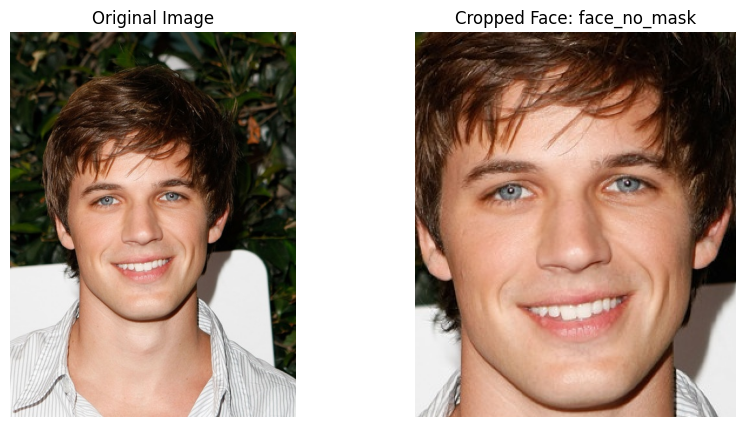

In [37]:
import cv2
import matplotlib.pyplot as plt

# Paths
img_file = os.path.join(image_dir, '1921.jpg')

# Load image
img = cv2.imread(img_file)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert BGR to RGB for correct colors in plt

# Get bounding box from the annotation
bbox = annotation_data['Annotations'][0]['BoundingBox']  # [x1, y1, x2, y2]
x1, y1, x2, y2 = bbox

# Crop the face region
face_img = img[y1:y2, x1:x2]
face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)

# Show original and cropped face side-by-side
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img_rgb)
plt.axis('off')

plt.subplot(1,2,2)
plt.title(f"Cropped Face: {annotation_data['Annotations'][0]['classname']}")
plt.imshow(face_img_rgb)
plt.axis('off')

plt.show()


**We compile the model using binary cross-entropy loss and the Adam optimizer. Then we train it on the training dataset while monitoring validation accuracy. We used 3 epochs to reduce time. **

In [38]:
import random
import numpy as np

img_size = 124  # image size for model input
labels_map = {'face_with_mask': 0, 'face_no_mask': 1}  # label encoding

data = []

for img_name in df_train['name'].unique():
    json_path = os.path.join(annotation_dir, img_name + '.json')
    img_path = os.path.join(image_dir, img_name)

    if not os.path.exists(json_path) or not os.path.exists(img_path):
        print(f"Skipping {img_name}: missing annotation or image")
        continue

    annotation_data = getJSON(json_path)
    annotations = annotation_data.get('Annotations', [])

    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image {img_path}")
        continue

    for ann in annotations:
        cls = ann['classname']
        if cls not in labels_map:
            continue

        x1, y1, x2, y2 = ann['BoundingBox']
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)

        if x2 <= x1 or y2 <= y1:
            continue

        face = img[y1:y2, x1:x2]
        if face.size == 0:
            continue

        face_resized = cv2.resize(face, (img_size, img_size))

        data.append([face_resized, labels_map[cls]])

random.shuffle(data)
print(f"Total samples collected: {len(data)}")


Total samples collected: 5749


In [39]:
# Separate features and labels
X = np.array([item[0] for item in data])
y = np.array([item[1] for item in data])

# Normalize pixel values to [0, 1]
X = X.astype('float32') / 255.0

# Split dataset: 80% train, 20% validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")


Training samples: 4599
Validation samples: 1150


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    15,745,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,838,529 (60.42 MB)

 Trainable params: 15,838,529 (60.42 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Extract features and labels from your data list
X = np.array([item[0] for item in data])
y = np.array([item[1] for item in data])

# Normalize images
X = X / 255.0

# Split into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")


Training samples: 4599
Validation samples: 1150


**We compile the model using binary cross-entropy loss and the Adam optimizer. Then we train it on the training dataset while monitoring validation accuracy. We used 3 epochs to reduce time. **

In [44]:
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator,
    verbose=1
)


Epoch 1/3
144/144 ━━━━━━━━━━━━━━━━━━━━ 584s 4s/step - accuracy: 0.8663 - loss: 0.3132 - val_accuracy: 0.9226 - val_loss: 0.2298
Epoch 2/3
144/144 ━━━━━━━━━━━━━━━━━━━━ 619s 4s/step - accuracy: 0.8935 - loss: 0.2640 - val_accuracy: 0.9209 - val_loss: 0.2103
Epoch 3/3
144/144 ━━━━━━━━━━━━━━━━━━━━ 580s 4s/step - accuracy: 0.9056 - loss: 0.2349 - val_accuracy: 0.9070 - val_loss: 0.2426


**We select random images from the validation set and run model predictions to see whether it correctly classifies faces as wearing masks or not. Both predicted and true labels are shown for visual inspection.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


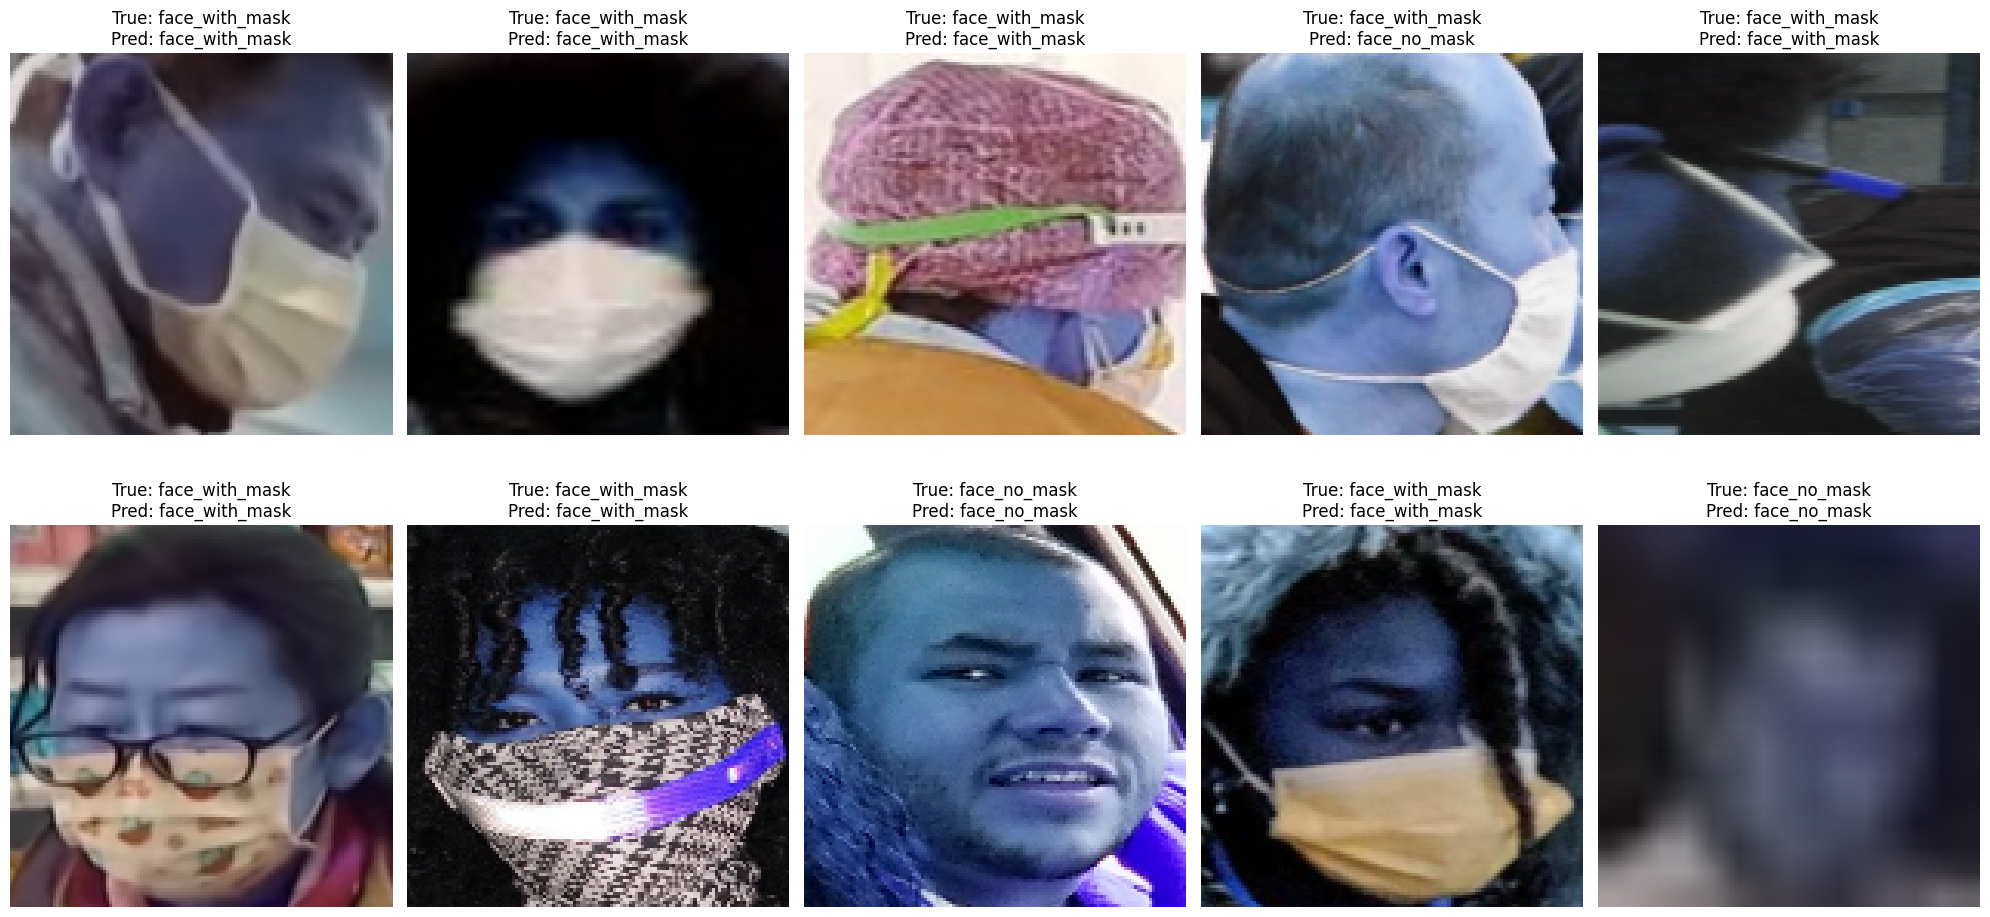

In [45]:
import matplotlib.pyplot as plt

# Mapping back the label
label_map_rev = {0: 'face_with_mask', 1: 'face_no_mask'}

# Predict on a few validation images
num_images = 10
plt.figure(figsize=(20, 10))

for i in range(num_images):
    idx = random.randint(0, len(X_val) - 1)
    img = X_val[idx]
    true_label = y_val[idx]

    pred = model.predict(np.expand_dims(img, axis=0))[0][0]
    predicted_label = 1 if pred > 0.5 else 0

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {label_map_rev[true_label]}\nPred: {label_map_rev[predicted_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
